* Reference: __A Machine Learning based Pairs Trading Investment Strategy__ by _Armento_ and _Nuno_ _Horta_

In [1]:
from IPython.display import Image

# Time Series appoach

## Introduction

Usually, when mean-reverting spread is constructed, a researcher will use Z-score Bollinger Band strategy to trade a portfolio. However, timeseries appoach may be applied to model the spread dynamics and enter long/short spread positions.

## Modelling the spread difference

- Firstly, let's define a spread in 2-dimensional space as $$S_t = Y_t - \beta X_t$$ Parameter $\beta$ can be define by either using Engle-Granger or Johansen cointegration appoach.
- Secondly, we need to come-up with a spread prediction model - it can be ARIMA, ANN, RNN or other time series prediction model. Let's define spread prediction at time $t$ as $\hat S_t$.
- On the third step, we split spread differences $S_t - S_{t-1}$ into positive ($f_{+}$) and negative ($f_{-}$). We define bottom negative differences quantile as $Q_{f_{-}}$ and top positive differences quantile as $Q_{f_{+}}$.

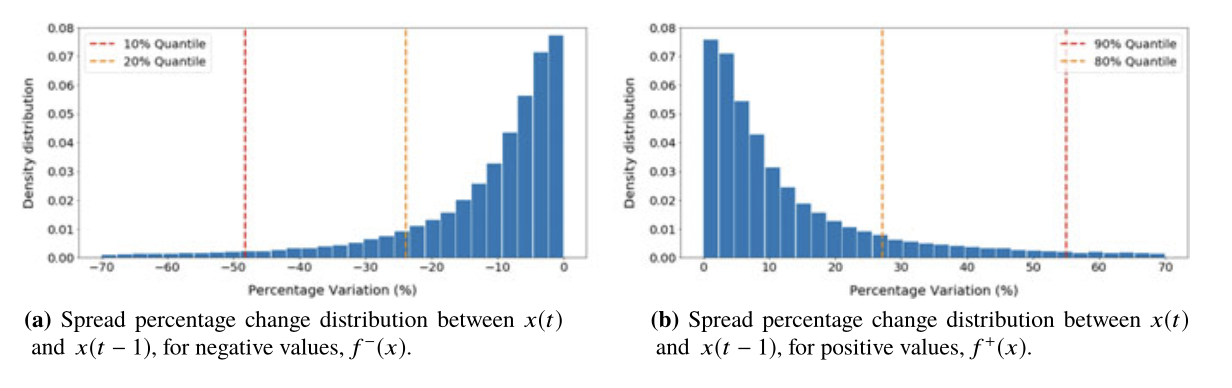

In [2]:
Image(filename='Time_Series/quantile_thresholds.png')

## Quantile-based trading
In time series approach our trading rule can be described as $$(\hat S_{t+1} - S_{t}) \geq Q_{f_{+}} \Rightarrow OPEN LONG $$ $$ (\hat S_{t+1} - S_{t}) \leq Q_{f_{-}} \Rightarrow OPEN SHORT $$ $$0 \leq \hat S_{t+1} - S_{t} \leq Q_{f_{+}} \Rightarrow HOLDLONG$$ $$Q_{f_{-}} \leq \hat S_{t+1} - S_{t} \leq 0 \Rightarrow HOLDSHORT$$. 

- OPENLONG/OPENSHORT means opening a new long/short position if none was opened before.
- HOLDLONG/HOLDSHORT means holding long/short positions if one was opened before.
- We should exit long position if HOLDLONG condition was not satisfied, we should exit short position if HOLDSHORT condition was not satisfied.

**Note**: we use __90%__ and __5%__ quantiles for top positive and bottom negative quantiles thresholds respectively and 0 value as exit threshold, however the researcher may decide what are the most optimal paramaters based on specific strategy.

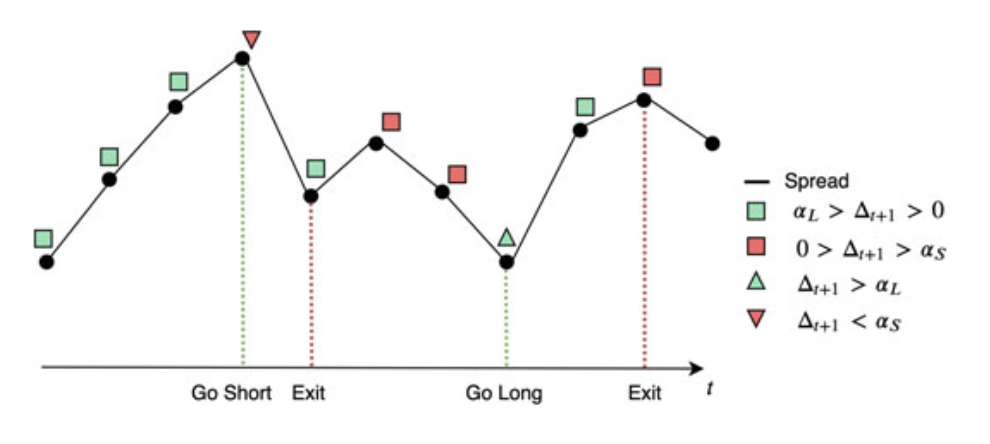

In [3]:
Image(filename='Time_Series/trading_example.png')

## Spread prediction model

In the notebook, we use __Auto ARIMA(p, d, q)__ approach to generate spread predictions. 
Non-seasonal ARIMA models are generally denoted ARIMA(p,d,q) where parameters p, d, and q are non-negative integers, __p__ is the order (number of time lags) of the autoregressive model, __d__ is the degree of differencing (the number of times the data have had past values subtracted), and __q__ is the order of the moving-average model.
In order to choose, best fit ARIMA model parameters we minimize **Akaike information criterion (AIC)** value: $$AIC = 2k - 2ln(L)$$ where $k$ - number of model parameters and $L$ - likelihood function.

As a part of arbitragelab, we have auto arima fit and prediction module which utilizes **pmdarima** package to find the best model fit.

## Usage of the Algorithms

Let's use the algorithm described above and its performance to Bollinger Bands Z-score strategy. 

- Firstly, we will use Engle-Granger to construct mean-reverting portfolio. 
- Secondly, we will fit Auto ARIMA model and generate predictions.
- On the third step, we will model spread differences and find trading thresholds.
- Finally, we will generate trading signals using Auto ARIMA and fit thresholds.

In [4]:
import arbitragelab as al
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Loading data

Following the example in the Optimal Mean Reversion module, we will use Gold Shares ETF (GLD), Gold Miners ETF (GDX), and Junior Gold Miners ETF (GDXJ) to construct a portfolio of three elements.

In [5]:
# Loading data
train_data =  yf.download("GLD GDX GDXJ", start="2016-01-01", end="2018-01-01")
test_data =  yf.download("GLD GDX GDXJ", start="2018-01-02", end="2019-08-01")

# Taking close prices for chosen instruments
train_three_elements = train_data["Adj Close"][["GLD", "GDX", "GDXJ"]]

test_three_elements = test_data["Adj Close"][["GLD", "GDX", "GDXJ"]]

# Looking at the downloaded data
train_three_elements.head()

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


,GLD,GDX,GDXJ
Date,,,
2015-12-31,101.459999,13.404492,18.068029
2016-01-04,102.889999,13.765984,18.622953
2016-01-05,103.180000,13.697593,18.660576
2016-01-06,104.669998,13.922304,18.980366
2016-01-07,106.150002,14.537816,19.422426


### Engle-Granger test

In [6]:
# Initialising an object containing needed methods
eg_portfolio = al.cointegration_approach.EngleGrangerPortfolio()

# Fitting the data on a dataset of three elements with constant term
eg_portfolio.fit(train_three_elements, add_constant=True)

# Getting results of the Engle-Granger test
eg_adf_statistics = eg_portfolio.adf_statistics
eg_cointegration_vectors = eg_portfolio.cointegration_vectors

In [7]:
# Looking at the statistic from the last step of the Engle-Granger test
eg_adf_statistics

,0
99%,-3.443418
95%,-2.867303
90%,-2.569840
statistic_value,-3.260982


Using the ADF statistic test output, we can see that our statistic is above the 95% significance level value.

So at a 95% significance level, our elements are cointegrated, we can construct a mean-reverting portfolio using the coefficients from the *eg_cointegration_vectors* variable.

In [8]:
eg_cointegration_vectors

,GLD,GDX,GDXJ
0,1.0,-3.202534,0.951377


As described in the theoretical part, the coefficient for the first element is $1$, while other two are equal to negative regression coefficients.

### Constructing portfolios

In [9]:
# Calculating returns of our elements (ETFs)
train_three_elements_returns = (train_three_elements / train_three_elements.shift(1) - 1)[1:]
test_three_elements_returns = (test_three_elements / test_three_elements.shift(1) - 1)[1:]

train_three_elements_returns.head()

,GLD,GDX,GDXJ
Date,,,
2016-01-04,0.014094,0.026968,0.030713
2016-01-05,0.002819,-0.004968,0.002020
2016-01-06,0.014441,0.016405,0.017137
2016-01-07,0.014140,0.044210,0.023290
2016-01-08,-0.004428,-0.024194,-0.028571


In [10]:
# Also adding weights to take initial prices of our ETFs into account
weights  = train_three_elements.iloc[0] / abs(train_three_elements.iloc[0]).sum()

In [11]:
# Weights of elements for the Engle-Granger portfolio
eg_cointegration_vectors.loc[0]

GLD     1.000000
GDX    -3.202534
GDXJ    0.951377
Name: 0, dtype: float64

In [12]:
# Scaling weights so they sum up to 1
eg_scaled_vectors = eg_cointegration_vectors.loc[0] / abs(eg_cointegration_vectors.loc[0]).sum()

eg_scaled_vectors

GLD     0.194027
GDX    -0.621379
GDXJ    0.184593
Name: 0, dtype: float64

In [13]:
# Calculating portfolio values during the training period
eg_portfolio_returns = (train_three_elements_returns * eg_scaled_vectors * weights).sum(axis=1)
eg_portfolio_price = (eg_portfolio_returns + 1).cumprod()

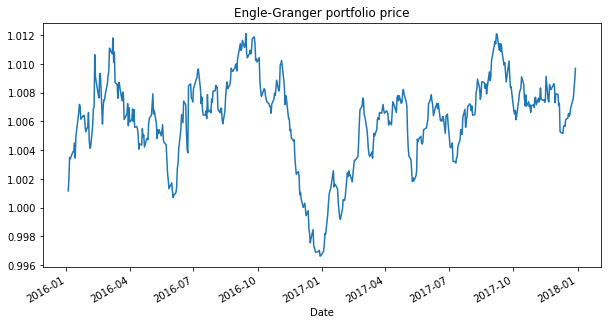

In [14]:
# Plotting Engle-Granger portfolio price
eg_portfolio_price.plot(title='Engle-Granger portfolio price', figsize=(10,5));

### Fit Auto ARIMA model

In [16]:
arima_model = AutoARIMAForecast(start_p=1, start_q=1, max_p=10, max_q=10)
#arima = ml.auto_arima.AutoARIMAForecast()

In [17]:
arima_model.get_best_arima_model(y_train=eg_portfolio_price, verbose=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5777.510, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5781.536, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5779.535, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5779.515, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5783.285, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.734 seconds


### Get trading thresholds (quantiles)

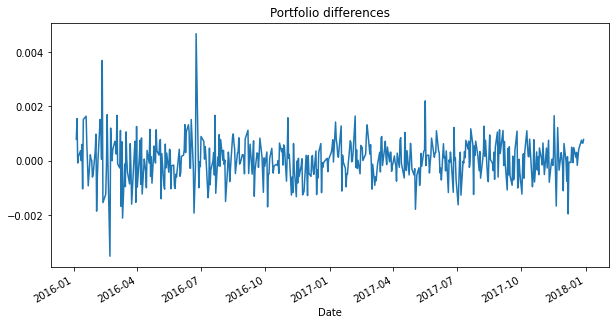

In [18]:
eg_portfolio_price.diff().plot(title='Portfolio differences', figsize=(10,5));

In [37]:
time_series_trading = al.other_approaches.QuantileTimeSeriesTradingStrategy() # Init strategy class
time_series_trading.fit_thresholds(eg_portfolio_price) # Fit portfilio to find Q_{-} and Q_{+}

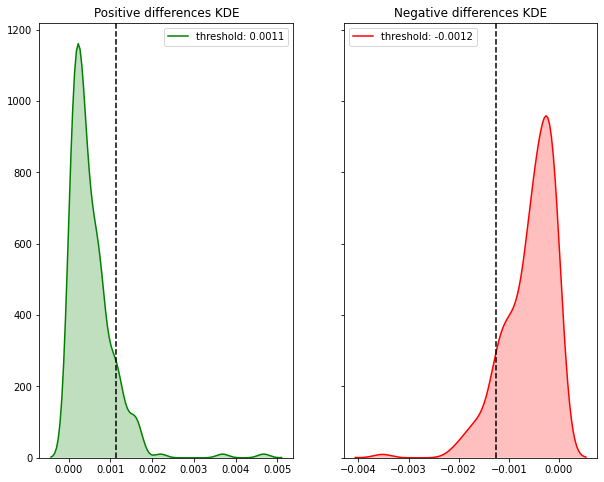

In [38]:
# Plot thresholds used for trading.
time_series_trading.plot_thresholds()

### Generate out-of-sample ARIMA predictions

In [21]:
# Creating a test portfolio based on the EG test results
test_three_elements_returns = (test_three_elements / test_three_elements.shift(1) - 1)[1:]

# Also adding weights to take initial prices of ETFs into account
weights  = test_three_elements.iloc[0] / abs(test_three_elements.iloc[0]).sum()

test_portfolio_returns = (test_three_elements_returns * eg_scaled_vectors * weights).sum(axis=1)

test_portfolio_price = (test_portfolio_returns + 1).cumprod()

In [22]:
# Generate ouf-of-sample ARIMA prediction
oos_prediction = arima_model.predict(y=test_portfolio_price)

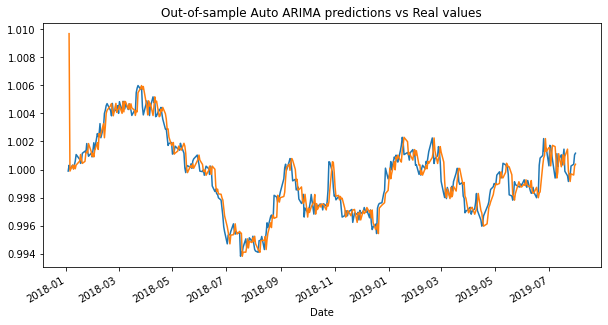

In [23]:
# Compare results
test_portfolio_price.plot(title='Engle-Granger OOS portfolio price', figsize=(10,5))
oos_prediction.plot(title='Out-of-sample Auto ARIMA predictions vs Real values', figsize=(10,5));

### Applying Time Series trading strategy

In [41]:
# Use difference between prediction and actual value to trade the spread
for prediction, actual in zip(test_portfolio_price, test_portfolio_price):
    time_series_trading.get_allocation(current_value=actual, prediction=prediction, exit_threshold=0)

In [42]:
# plot positions created using time series approach
positions = pd.Series(index=test_portfolio_price.index, data=time_series_trading.positions)
long_positions = positions[positions == 1]
short_positions = positions[positions == -1]
test_portfolio_price.plot(title='Engle-Granger OOS portfolio price', figsize=(10,5), label='portfolio')
plt.scatter(long_positions.index, test_portfolio_price.loc[long_positions.index], color='green', label='long positions')
plt.scatter(short_positions.index, test_portfolio_price.loc[short_positions.index], color='red', label='short positions')
plt.legend(loc='best');

ValueError: Length of passed values is 792, index implies 396.

### Applying Bollinger Bands trading strategy

This trading strategy requires defining entry and exit Z-scores. Let's choose the entry Z-score - upon which the strategy will enter a short position, going short one unit of a portfolio. This position will be closed once the exit Z-score will be reached and the position of the opposite side will be opened.

In our example, we will be using an entry Z-score of 2 and an exit Z-score of -2.

In [ ]:
# Importing the needed function
from arbitragelab.cointegration_approach import bollinger_bands_trading_strategy

In [ ]:
# Applying Bollinger Bands trading strategy
bollinger_trading_results = bollinger_bands_trading_strategy(test_portfolio_price,
                                                 sma_window = int(j_half_life),
                                                 std_window = int(j_half_life),
                                                 entry_z_score=2,
                                                 exit_z_score=-2)

bollinger_trading_results.tail()

In [ ]:
# Plotting the results
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(10,7))
fig.suptitle('Bollinger Bands trading strategy results')

axs[0].plot(bollinger_trading_results.iloc[:,0])
axs[0].title.set_text('Portfolio price')

axs[1].plot(bollinger_trading_results.iloc[:,2], '#b11a21')
axs[1].title.set_text('Number of portfolio units to hold')

Again, the upper graph shows the price of a mean-reverting portfolio - the same price series that were used as an input to the bollinger_bands_trading_strategy function. The lower graph shows the target amount of portfolio units to hold at any given time. Note that the amount invested is limited to 1 portfolio unit - long or short.

From the above example, the Bollinger Bands strategy is generating multiple signals to open long and short positions on our mean-revering portfolio.

Let's calculate the equity curve of our portfolio, if we would use this trading strategy on this data. We should shift the trading signals one observation ahead to avoid the lookahead bias in this example.

In [ ]:
# Calculating the price of our investment portfolio
investment_portfolio_retunrs = test_portfolio_returns * bollinger_trading_results.iloc[:,2].shift(1)

investment_portfolio_price = (investment_portfolio_retunrs + 1).cumprod()

In [ ]:
# Calculating the equity curve of our investment portfolio
investment_portfolio_equity_curve = investment_portfolio_price - 1

# Plotting the equity curve
investment_portfolio_equity_curve.plot(title='Bollinger Bands investemnt portfolio equity curve', figsize=(10,5));

Using trading signals from the Bollinger Bands strategy for this particular example resulted in the value of our investment portfolio increasing from 1 in mid-September 2018 to around 1.01 at the beginning of the year 2020.

We can further test this strategy by choosing different entry and exit Z-scores, or adding transaction costs to see if the strategy is robust.

## Conclusion

This notebook describes the Mean Reversion module tools - cointegration tests and trading strategies. Also, it shows how these tools can be used on real data and that they can output profitable trading signals.

The algorithms and the descriptions used in this notebook were described by _Ernest P. Chan_ in the book __Algorithmic Trading: Winning Strategies and Their Rationale__  [available here](https://www.wiley.com/en-us/Algorithmic+Trading%3A+Winning+Strategies+and+Their+Rationale-p-9781118460146).

Key takeaways from the notebook:

- Mean-reverting processes tend to move to their average value over time. However, most financial price series are not mean-reverting.
- Financial instruments can be combined in a portfolio that has mean-reverting properties.
- ADF test allows testing if the next price move depends on the current price level.
- Half-life of a mean-reverting process indicates how long it takes for a price to mean revert.
- Both Johansen and Engle-Granger cointegration tests allow testing if we can construct a mean-reverting portfolio out of multiple price series, and if so, which combination of these elements should we use to construct a portfolio.
- Constructed portfolios can be used in the Linear and Bollinger Bands trading strategies.
- The Bollinger Bands  strategy  deals with the issues present in the linear strategy: infinitesimal portfolio rebalances and no predefined buying power.